#### Helper Functions

In [3]:
# Plot colors
lblue="#a6cee3"
blue = "#1f78b4"
lgreen = "#b2df8a"
green = "#33a02c"
black= "#424242"


from os import path, remove
import sys
import csv
import subprocess
from subprocess import call,check_output, DEVNULL
from pandas import read_csv
from os import path
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MaxNLocator

def validate_args(datasetSize, distribution, parameter, searchAlgo, recordSizeBytes, nThreads):
    if recordSizeBytes not in [8,32,128]:
        print("The valid record size options are 8,32,128")
        exit()

# Adds a experiment to the tsv configuration file. Each experiment described the dataset 
# that is going to be searched and which search algorithm is going to be used.
# Input Args:
#             tsvpath: the path of the tsvfile
#             datasetSize: number of records of the dataset to be searched
#             distribution: distribution of the keys of the dataset to be searched
#             parameter:    datasets parameter
#             searchAlgo: name of the search algorithm to use
#             recordSizeBytes: size of record (key + payload)
#             nThreads: number of threads to be used for search
def add_to_tsv(tsvpath, datasetSize, distribution, parameter, searchAlgo, recordSizeBytes, nThreads):
    validate_args(datasetSize, distribution, parameter,searchAlgo, recordSizeBytes, nThreads)
    if not path.exists("results/"+tsvpath):
        with open("results/"+tsvpath, "w") as f:
            f.write("DatasetSize\tDistribution\tParameter\tSearchAlgorithm\tRecordSizeBytes\t#threads\n")
    with open("results/"+tsvpath, "a") as f:
        conf = str(datasetSize)+"\t"+ \
               str(distribution)+"\t"+ \
               str(parameter)+"\t"+ \
               str(searchAlgo)+"\t"+ \
               str(recordSizeBytes)+"\t"+ \
               str(nThreads)+"\n"
        f.write(conf)
    
def rm_tsv(tsvpath):
    if path.exists("results/"+tsvpath):
        remove("results/"+tsvpath)

def UaR_to_tsv(tsvpath, datasetSize, searchAlgo, recordSizeBytes, nThreads, parameter=42):
    add_to_tsv(tsvpath, datasetSize, "uniform", parameter, searchAlgo, recordSizeBytes, nThreads)
    
def fbids_to_tsv(tsvpath, searchAlgo, recordSizeBytes, nThreads):
    add_to_tsv(tsvpath, 1, "file", "src/datasets/fb/fb-289000.txt", searchAlgo, recordSizeBytes, nThreads)
    
def freq1_to_tsv(tsvpath, searchAlgo, recordSizeBytes, nThreads):
    add_to_tsv(tsvpath, 1, "file", "src/datasets/wf/wiki.txt", searchAlgo, recordSizeBytes, nThreads)
    
def freq2_to_tsv(tsvpath, searchAlgo, recordSizeBytes, nThreads):
    add_to_tsv(tsvpath, 1, "file", "src/datasets/wf/newman.txt", searchAlgo, recordSizeBytes, nThreads)

def fal_to_tsv(tsvpath, searchAlgo, recordSizeBytes, nThreads, parameter, datasetSize):
    add_to_tsv(tsvpath, datasetSize, "fal", parameter, searchAlgo, recordSizeBytes, nThreads)

def cfal_to_tsv(tsvpath, searchAlgo, recordSizeBytes, nThreads, parameter, datasetSize):
    add_to_tsv(tsvpath, datasetSize, "cfal", parameter, searchAlgo, recordSizeBytes, nThreads)

def gap_to_tsv(tsvpath, searchAlgo, recordSizeBytes, nThreads, random_seed, shape, datasetSize):
    add_to_tsv(tsvpath, datasetSize, "gap", str(random_seed)+","+str(shape), searchAlgo, recordSizeBytes, nThreads)
    
def run(tsvname):
    if not path.exists("../searchbench"):
        print("Please make sure searchbench is compiled. You can compile this by running make on the parent directory.")
        sys.exit()
        
    resultFile="results/"+tsvname+".out"
    if path.exists(resultFile):
        print("This tsv has been already executed and the results have been saved.")
        print("If you want to rerun the experiments please delete the file: "+tsvname+".out")
    else:
        with open(resultFile, "w") as log_file:
            subprocess.run(["python3","./getTimes.py","./reproduce_experiments/results/"+tsvname], stdout=log_file, stderr=DEVNULL, cwd="../") 
            
            
def get_results(tsvname):
    times=[]
    with open("results/"+tsvname+".out", newline='') as csvfile:
        csvreader = csv.reader(csvfile, delimiter='\t')
        for row in csvreader:
            if len(row)>0 and row[0][0].isdigit():
                times.append(float(row[0].split()[7]))
    return times

def fullConfiguration():
    if not path.exists("configuration.txt"):
        print("Running experiments in reduced mode.")
        return False
    with open("configuration.txt") as conf:
        for line in conf:
            if "full" in line:
                return True
            else:
                return False
                
makePlots=False



#### Figure 2

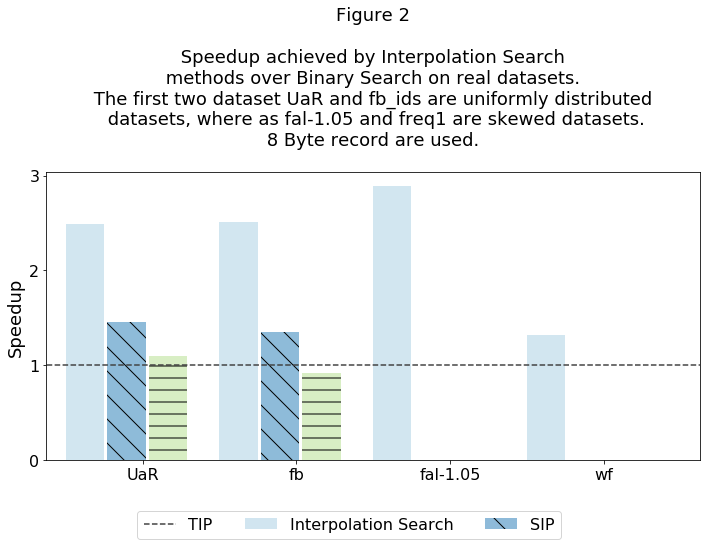

In [4]:
tsv = "fig2.tsv"
rm_tsv(tsv)

# A smaller size allows experiments to finish faster

size=5
if fullConfiguration():
    size=8

for algorithm in ["bs", "sip", "is", "tip"]:
    UaR_to_tsv(tsv, 10**size, algorithm, 8, 1)
    
for algorithm in ["bs", "sip", "is", "tip"]:
    fbids_to_tsv(tsv, algorithm, 8, 1) 
    
for algorithm in ["bs", "tip"]:
    fal_to_tsv(tsv, algorithm, 8, 1, 1.05, 10**size) 

for algorithm in ["bs", "tip"]:
    freq1_to_tsv(tsv, algorithm, 8, 1)

run(tsv)
results=get_results(tsv)

if makePlots:
    uarResults=results[0:4]
    fbidsResults=results[4:8]
    falResults=results[8:10]
    freq1Results=results[10:12]

    # Calculate speedups of sip, is and tip compard to Binary Search
    uarSpeedups = []
    for i in range(1,len(uarResults)):
        uarSpeedups.append(uarResults[0]/uarResults[i])

    fbidsSpeedups = []
    for i in range(1,len(fbidsResults)):
        fbidsSpeedups.append(fbidsResults[0]/fbidsResults[i])

    falSpeedups = []
    for i in range(1,len(falResults)):
        falSpeedups.append(falResults[0]/falResults[i])

    freq1Speedups = []
    for i in range(1,len(freq1Results)):
        freq1Speedups.append(freq1Results[0]/freq1Results[i])


    # Plot
    # Group the speedups by algorithm
    tipSpeedups=[uarSpeedups[0], fbidsSpeedups[0], falSpeedups[0], freq1Speedups[0]]
    ISSpeedups=[uarSpeedups[1], fbidsSpeedups[1],0,0]
    sipSpeedups=[uarSpeedups[2], fbidsSpeedups[2],0,0]

    labels=["UaR", "fb", "fal-1.05", "wf"]
    pos = [0,1,2,3]
    width = 0.25 

    caption = "Figure 2\n\n Speedup achieved by Interpolation Search \n methods over Binary Search on real datasets. \n The first two dataset UaR and fb_ids are uniformly distributed \n datasets, where as fal-1.05 and freq1 are skewed datasets.\n 8 Byte record are used. \n"

    fig, ax = plt.subplots(figsize=(10,8))
    plt.bar(pos, 
            tipSpeedups, 
            width, 
            alpha=0.5, 
            color=lblue, 
            label="TIP") 

    plt.bar([p + width+.02 for p in pos], 
            ISSpeedups,
            width, 
            alpha=0.5, 
            color=blue, 
            label="Interpolation Search",
            hatch="\\") 

    plt.bar([p + width*2+.04 for p in pos], 
            sipSpeedups,
            width, 
            alpha=0.5, 
            color=lgreen, 
            label="SIP",
            hatch="-") 

    plt.plot([-1,5],[1,1],linestyle="dashed", color=black, label="BS")

    ax.set_ylabel('Speedup', size=18)

    ax.set_title(caption, size=18)

    # Set the position of the x ticks
    ax.set_xticks([p + 1.5 * width for p in pos])
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))

    # Set the labels for the x ticks
    ax.set_xticklabels(labels, size=15)
    ax.tick_params(axis='both', which='major', labelsize=16)

    # Setting the x-axis and y-axis limits
    plt.xlim(min(pos)-width, max(pos)+width*4)
    # plt.ylim([0, max(df['pre_score'] + df['mid_score'] + df['post_score'])] )

    # Adding the legend and showing the plot
    # plt.legend(prop={'size': 22}, ncol=3, loc='upper right', bbox_to_anchor=(0.7, -0.15))
    plt.legend(['TIP', 'Interpolation Search', 'SIP'], ncol=4, bbox_to_anchor=(.8, -0.15), loc='upper right',prop={'size': 16})
    plt.tight_layout()
    plt.gcf().savefig('./figures/fig2.pdf', format='pdf')



#### Figure 5

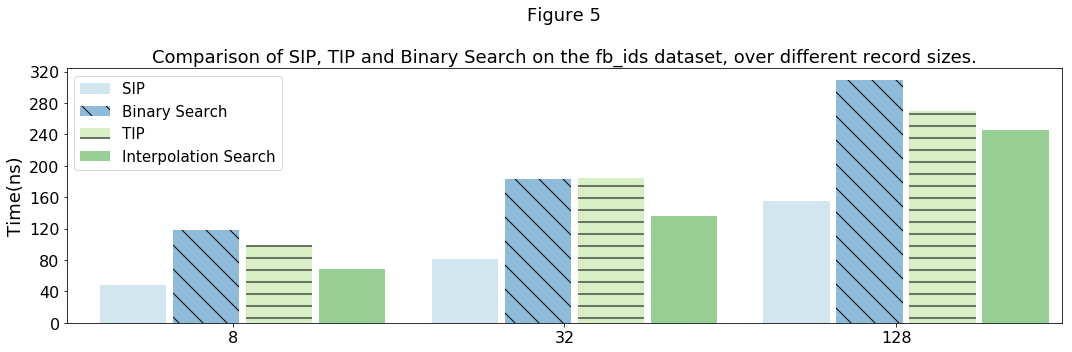

In [5]:
tsv="fig5.tsv"
rm_tsv(tsv)

for recordSize in [8,32,128]:
    for algorithm in ["sip", "bs", "tip", "is"]:
        fbids_to_tsv(tsv, algorithm, recordSize, 1)

run(tsv)
results=get_results(tsv)
if makePlots:
    # Plot
    # Group the results by algorithm
    sipResult=[results[0], results[4], results[8]]
    bsResult=[results[1], results[5], results[9]]
    tipResult=[results[2], results[6], results[10]]
    isResult=[results[3], results[7], results[11]]

    pos = [0,1,2]
    width = 0.20 

    fig, ax = plt.subplots(figsize=(15,5))
    plt.bar(pos, 
            sipResult, 
            width, 
            alpha=0.5, 
            color=lblue, 
            label="SIP") 

    plt.bar([p + (width+.02)*1 for p in pos], 
            bsResult,
            width, 
            alpha=0.5, 
            color=blue, 
            label="Binary Search",
            hatch="\\") 

    plt.bar([p + (width+.02)*2 for p in pos], 
            tipResult,
            width, 
            alpha=0.5, 
            color=lgreen, 
            label="TIP",
            hatch="-")

    plt.bar([p + (width+.02)*3 for p in pos], 
            isResult,
            width, 
            alpha=0.5, 
            color=green, 
            label="Interpolation Search") 

    ax.set_ylabel('Time(ns)', size=18)

    ax.set_title('Figure 5', size=22)

    # Set the position of the x ticks
    ax.set_xticks([p + 1.5 * width for p in pos])
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))

    # Set the labels for the x ticks
    ax.set_xticklabels(["8","32","128"], size=15)
    ax.tick_params(axis='both', which='major', labelsize=16)

    # Setting the x-axis and y-axis limits
    plt.xlim(min(pos)-width, max(pos)+width*4)
    # plt.ylim([0, max(df['pre_score'] + df['mid_score'] + df['post_score'])] )

    # Adding the legend and showing the plot
    caption = "Figure 5\n\nComparison of SIP, TIP and Binary Search on the fb_ids dataset, over different record sizes."
    plt.title(caption, size=18)
    plt.tight_layout()
    plt.legend(['SIP', 'Binary Search', 'TIP', 'Interpolation Search' ], loc='upper right')
    plt.legend(prop={'size': 15})


    plt.gcf().savefig('./figures/fig5.pdf', format='pdf')




#### Figure 6

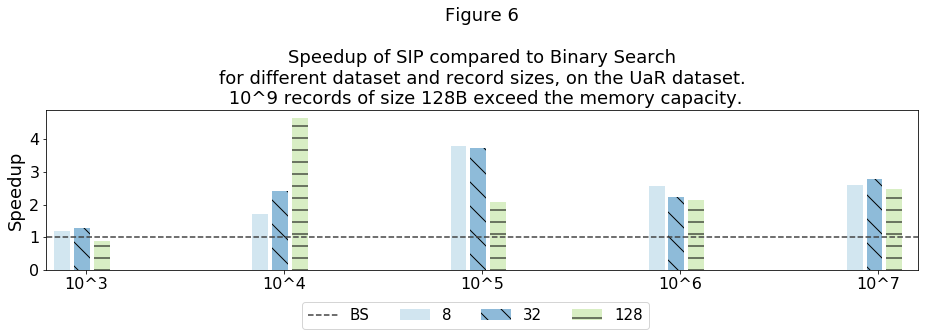

In [6]:
tsv="fig6.tsv"
rm_tsv(tsv)

# Less dataset sizes allow the experiments to finish faster
datasetSizes=[3,4,5,6,7]#,8,9]
if fullConfiguration():
    datasetSizes=[3,4,5,6,7,8,9]

for algorithm in ["bs", "sip"]:
    for datasetSize in datasetSizes:
        for recordSize in [8,32,128]:
            UaR_to_tsv(tsv, 10**datasetSize, algorithm, recordSize, 1)   
            
run(tsv)
results=get_results(tsv)

if makePlots:
    # Group the results by algorithm
    bsResults=results[0:(len(results)//2)]
    sipResults=results[(len(results)//2):len(results)]

    # Calculate speedup
    sipSpeedup=[(bsResults[i]/sipResults[i]) for i in range(len(bsResults))]

    # Plot
    # Group the speedups by RecordSize
    groupedByRecordSize = [[],[],[]]
    for i in range(len(datasetSizes)):
        groupedByRecordSize[0].append(sipSpeedup[3*i])
        groupedByRecordSize[1].append(sipSpeedup[3*i+1])
        groupedByRecordSize[2].append(sipSpeedup[3*i+2])

    pos = [i for i in range(len(datasetSizes))]
    width = 0.08

    fig, ax = plt.subplots(figsize=(13,5))


    plt.bar(pos, 
            groupedByRecordSize[0], 
            width, 
            alpha=0.5, 
            color=lblue, 
            label="8") 

    plt.bar([p + (width+.02)*1 for p in pos], 
            groupedByRecordSize[1],
            width, 
            alpha=0.5, 
            color=blue, 
            label="32",
            hatch="\\") 

    plt.bar([p + (width+.02)*2 for p in pos], 
            groupedByRecordSize[2],
            width, 
            alpha=0.5, 
            color=lgreen, 
            label="128",
            hatch="-")

    plt.plot([-1,len(datasetSizes)],[1,1],linestyle="dashed", color=black, label="BS")

    ax.set_ylabel('Speedup', size=18)

    ax.set_title('Figure 6', size=22)

    # Set the position of the x ticks
    ax.set_xticks([p + 1.5 * width for p in pos])
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))

    # Set the labels for the x ticks
    xticks=["10^"+str(i) for i in datasetSizes]
    ax.set_xticklabels(xticks, size=15)
    ax.tick_params(axis='both', which='major', labelsize=16)

    # Setting the x-axis and y-axis limits
    plt.xlim(min(pos)-width, max(pos)+width*4)
    # plt.ylim([0, max(df['pre_score'] + df['mid_score'] + df['post_score'])] )

    # Adding the legend and showing the plot
    plt.legend(prop={'size': 15}, ncol=4, loc='upper right', bbox_to_anchor=(0.7, -0.15))
    caption = "Figure 6\n\nSpeedup of SIP compared to Binary Search\nfor different dataset and record sizes, on the UaR dataset.\n 10^9 records of size 128B exceed the memory capacity."
    plt.title(caption, size=18)
    plt.tight_layout()
    plt.gcf().savefig('./figures/fig6.pdf', format='pdf')



#### Figure 7

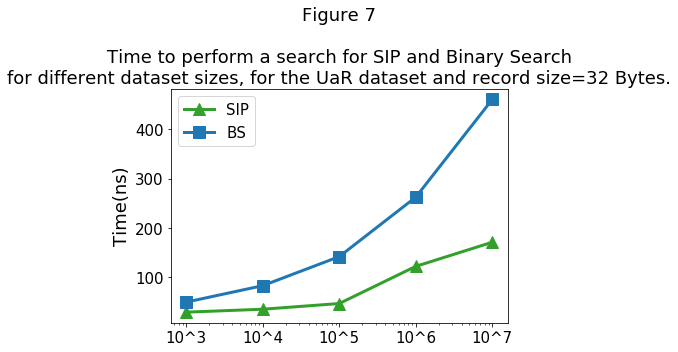

In [7]:
tsv="fig7.tsv"
rm_tsv(tsv)

# Less dataset sizes allow the experiments to finish faster
datasetSizes=[3,4,5,6,7]#,8,9]
if fullConfiguration():
    datasetSizes=[3,4,5,6,7,8,9]

for algorithm in ["bs", "sip"]:
    for datasetSize in datasetSizes:
            UaR_to_tsv(tsv, 10**datasetSize, algorithm, 32, 1)  

            
run(tsv)
results=get_results(tsv)

if makePlots:
    # Group the results by algorithm
    bsResults=results[0:(len(results)//2)]
    sipResults=results[(len(results)//2):len(results)]


    fig, ax = plt.subplots(figsize=(8,5))

    plt.plot([10**i for i in datasetSizes], sipResults, color=green,marker="^", markersize=12, linewidth=3, label="SIP")
    plt.plot([10**i for i in datasetSizes], bsResults, color=blue,marker="s", markersize=12, linewidth=3, label="BS")

    ax.set_ylabel('Time(ns)', size=18)
    ax.set_title('Figure 7', size=22)
    ax.set_xscale('log')

    # Set the position of the x ticks
    ax.set_xticks([10**i for i in datasetSizes] )
    ax.set_xticklabels(["10^"+str(i) for i in datasetSizes], size=15)
    ax.tick_params(axis="y", labelsize=15)

    # Adding the legend and showing the plot
    plt.legend(prop={'size': 15}, loc='upper left')
    caption = "Figure 7\n\nTime to perform a search for SIP and Binary Search\nfor different dataset sizes, for the UaR dataset and record size=32 Bytes."
    plt.title(caption, size=18)
    plt.tight_layout()
    plt.gcf().savefig('./figures/fig7.pdf', format='pdf')

#### Figure 8

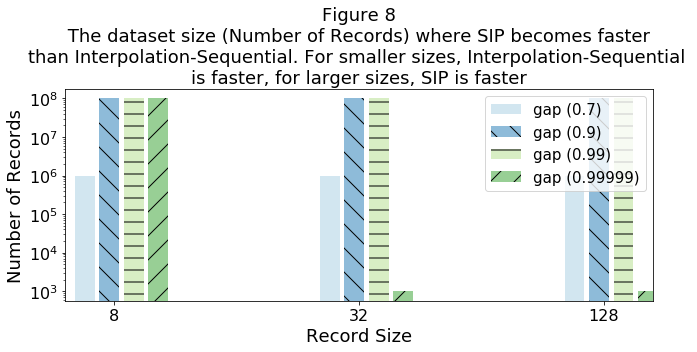

In [8]:
tsv8="fig8_8.tsv"
tsv32="fig8_32.tsv"
tsv128="fig8_128.tsv"
rm_tsv(tsv8)
rm_tsv(tsv32)
rm_tsv(tsv128)

datasetSizes=[3,5,6,7]
for algorithm in ["sip", "isseq"]:
    for gapShape in [0.7,0.9,0.99,0.99999]:
        for datasetSize in datasetSizes:
            gap_to_tsv(tsv8, algorithm, 8, 1, 47,gapShape, 10**datasetSize)
            gap_to_tsv(tsv8, algorithm, 8, 1, 47,gapShape, 10**datasetSize)
            gap_to_tsv(tsv8, algorithm, 8, 1, 47,gapShape, 10**datasetSize)
            gap_to_tsv(tsv8, algorithm, 8, 1, 47,gapShape, 10**datasetSize)
                
for algorithm in ["sip", "isseq"]:
    for gapShape in [0.7,0.9,0.99,0.99999]:
        for datasetSize in datasetSizes:
            gap_to_tsv(tsv32, algorithm, 32, 1, 47,gapShape, 10**datasetSize)
            gap_to_tsv(tsv32, algorithm, 32, 1, 47,gapShape, 10**datasetSize)
            gap_to_tsv(tsv32, algorithm, 32, 1, 47,gapShape, 10**datasetSize)
            gap_to_tsv(tsv32, algorithm, 32, 1, 47,gapShape, 10**datasetSize)
                
for algorithm in ["sip", "isseq"]:
    for gapShape in [0.7,0.9,0.99,0.9999]:
        for datasetSize in datasetSizes:
            gap_to_tsv(tsv128, algorithm, 128, 1, 47,gapShape, 10**datasetSize)
            gap_to_tsv(tsv128, algorithm, 128, 1, 47,gapShape, 10**datasetSize)
            gap_to_tsv(tsv128, algorithm, 128, 1, 47,gapShape, 10**datasetSize)
            gap_to_tsv(tsv128, algorithm, 128, 1, 47,gapShape, 10**datasetSize)
            
run(tsv8)
run(tsv32)
run(tsv128)
results8=get_results(tsv8)[0::4]
results32=get_results(tsv32)[0::4]
results128=get_results(tsv128)[0::4]

if makePlots:
    shape1=[len(datasetSizes)+1 for i in range(0,3)]
    shape2=[len(datasetSizes)+1 for i in range(0,3)]
    shape3=[len(datasetSizes)+1 for i in range(0,3)]
    shape4=[len(datasetSizes)+1 for i in range(0,3)]

    def analyzeResults(results, shape1, shape2, shape3, shape4, rc):
        sipResults=results[0:(len(results)//2)]
        isseqResults=results[(len(results)//2):len(results8)]

        sipResultsShape1=sipResults[0:len(datasetSizes)]
        sipResultsShape2=sipResults[len(datasetSizes):2*len(datasetSizes)]
        sipResultsShape3=sipResults[2*len(datasetSizes):3*len(datasetSizes)]
        sipResultsShape4=sipResults[3*len(datasetSizes):4*len(datasetSizes)]

        isseqResultsShape1=isseqResults[0:len(datasetSizes)]
        isseqResultsShape2=isseqResults[len(datasetSizes):2*len(datasetSizes)]
        isseqResultsShape3=isseqResults[2*len(datasetSizes):3*len(datasetSizes)]
        isseqResultsShape4=isseqResults[3*len(datasetSizes):4*len(datasetSizes)]

        for i in range(0,len(datasetSizes)):
            if sipResultsShape1[i] < isseqResultsShape1[i]:
                shape1[rc]=(i)
                break
        for i in range(0,len(datasetSizes)):
            if sipResultsShape2[i] < isseqResultsShape2[i]:
                shape2[rc]=(i)
                break
        for i in range(0,len(datasetSizes)):
            if sipResultsShape3[i] < isseqResultsShape3[i]:
                shape3[rc]=(i)
                break
        for i in range(0,len(datasetSizes)):
            if sipResultsShape4[i] < isseqResultsShape4[i]:
                shape4[rc]=(i)
                break

    analyzeResults(results8, shape1, shape2, shape3, shape4,0)
    analyzeResults(results32, shape1, shape2, shape3, shape4,1)
    analyzeResults(results128, shape1, shape2, shape3, shape4,2)

    shape1=[10**(3+i) for i in shape1]
    shape2=[10**(3+i) for i in shape2]
    shape3=[10**(3+i) for i in shape3]
    shape4=[10**(3+i) for i in shape4]

    pos = [0,1,2]
    fig, ax = plt.subplots(figsize=(10,5))
    plt.bar(pos, 
            shape1, 
            width, 
            alpha=0.5, 
            color=lblue, 
            label="gap (0.7)") 

    plt.bar([p + width+.02 for p in pos], 
            shape2,
            width, 
            alpha=0.5, 
            color=blue, 
            label="gap (0.9)",
            hatch="\\") 

    plt.bar([p + width*2+.04 for p in pos], 
            shape3,
            width, 
            alpha=0.5, 
            color=lgreen, 
            label="gap (0.99)",
            hatch="-") 

    plt.bar([p + width*3+.06 for p in pos], 
            shape4,
            width, 
            alpha=0.5, 
            color=green, 
            label="gap (0.99999)",
            hatch="/") 


    ax.set_ylabel('Number of Records', size=18)
    ax.set_xlabel('Record Size', size=18)
    ax.set_yscale('log')
    caption = "Figure 8\n The dataset size (Number of Records) where SIP becomes faster \nthan Interpolation-Sequential. For smaller sizes, Interpolation-Sequential \nis faster, for larger sizes, SIP is faster"
    ax.set_title(caption, size=18)

    # Set the position of the x ticks
    ax.set_xticks([p + 1.5 * width for p in pos])
    labels=["8","32","128"]
    # Set the labels for the x ticks
    ax.set_xticklabels(labels, size=15)
    ax.tick_params(axis='both', which='major', labelsize=16)

    # Setting the x-axis and y-axis limits
    plt.xlim(min(pos)-width, max(pos)+width*4)
    # plt.ylim([0, max(df['pre_score'] + df['mid_score'] + df['post_score'])] )

    # Adding the legend and showing the plot
    plt.legend(['gap (0.7)', 'gap (0.9)', 'gap (0.99)', 'gap (0.99999)'], loc='upper right')
    plt.legend(prop={'size': 15})
    plt.tight_layout()
    plt.gcf().savefig('./figures/fig8.pdf', format='pdf')



#### Figure 9

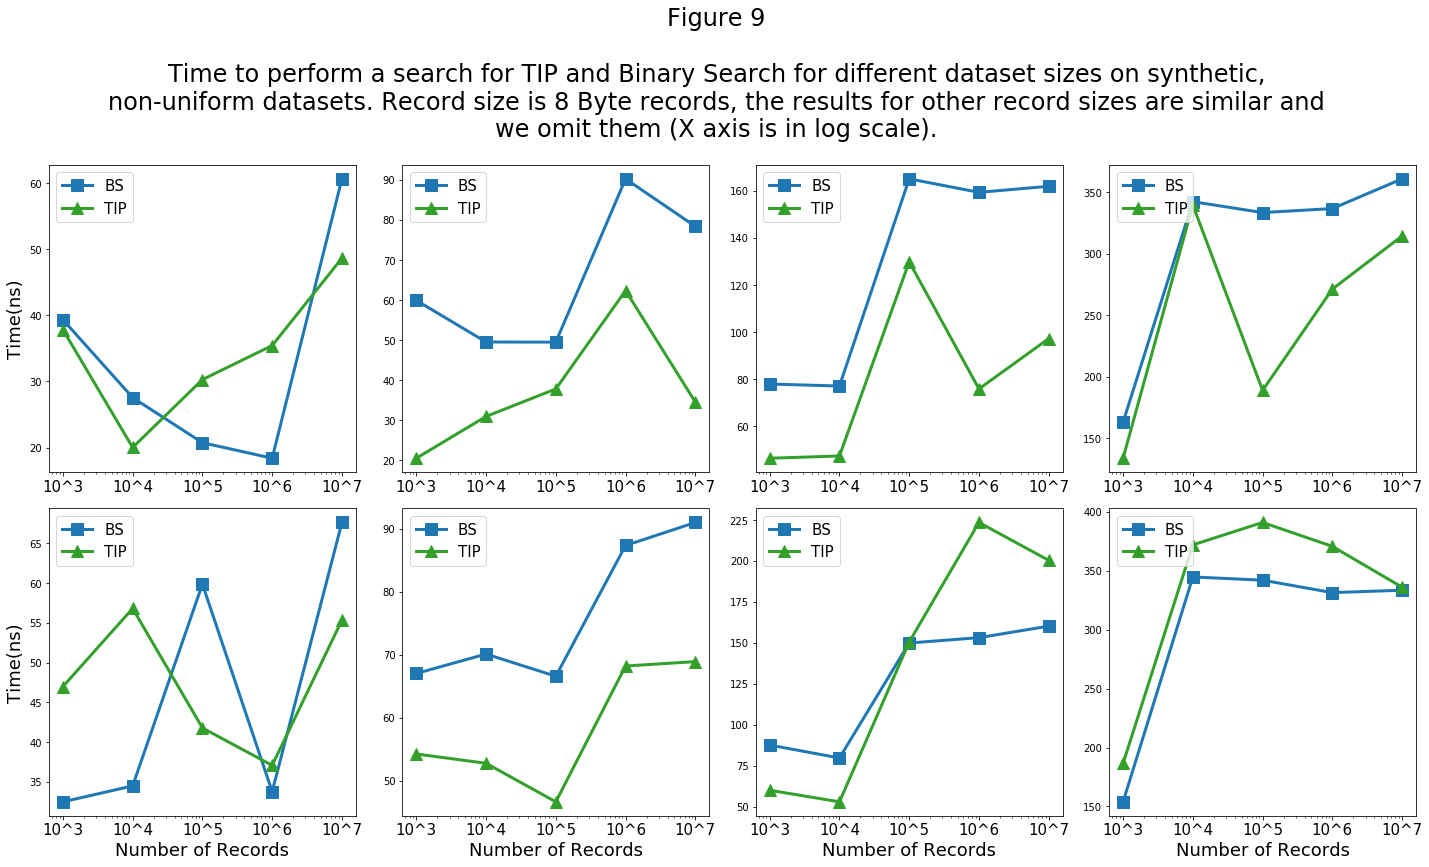

In [9]:
tsv="fig9.tsv"
rm_tsv(tsv)
tsv_caches="fig9_cache.tsv"

# Less dataset sizes allow the experiments to finish faster
datasetSizes=[3,4,5,6,7]#,8,9]
if fullConfiguration():
    datasetSizes=[3,4,5,6,7,8,9]

shapes = [0.5,1.05,1.25,1.5]
for algorithm in ["bs", "tip"]:
    for datasetSize in datasetSizes:
        for shape in shapes:
            #cache warm up
            fal_to_tsv(tsv, algorithm, 8, 1, shape, 10**datasetSize)
            fal_to_tsv(tsv, algorithm, 8, 1, shape, 10**datasetSize)
            #actual experiment
            fal_to_tsv(tsv, algorithm, 8, 1, shape, 10**datasetSize)

for algorithm in ["bs", "tip"]:
    for datasetSize in datasetSizes:
        for shape in shapes:
            #cache warm up
            cfal_to_tsv(tsv, algorithm, 8, 1, shape, 10**datasetSize)
            cfal_to_tsv(tsv, algorithm, 8, 1, shape, 10**datasetSize)
            #actual experiment
            cfal_to_tsv(tsv, algorithm, 8, 1, shape, 10**datasetSize)

run(tsv)
results=get_results(tsv)[0::3]

if makePlots:
    # Group Results by algorithm
    falResults=results[0:(len(results)//2)]
    cfalResults=results[(len(results)//2):len(results)]

    bsResults=falResults[0:(len(falResults)//2)]
    bsResults.extend(cfalResults[0:(len(cfalResults)//2)])

    tipResults=falResults[(len(falResults)//2):len(falResults)]
    tipResults.extend(cfalResults[(len(cfalResults)//2):len(cfalResults)])


    # Group results by plot
    perPlot=[]
    for i in range(0,8):
        perPlot.append([[],[]])
        for j in range(0, len(datasetSizes)):
            perPlot[i][0].append(bsResults[len(datasetSizes)*i+j])
            perPlot[i][1].append(tipResults[len(datasetSizes)*i+j])


    # Plot Helpers        
    xticks=["10^"+str(i) for i in datasetSizes]
    datasetSizesPlot=[]
    for i in datasetSizes:
        datasetSizesPlot.append(10**i)


    figs, axs = plt.subplots(2,4,figsize=(20,10))
    for i in range(0, len(shapes)):
        axs[0,i].plot(datasetSizesPlot, perPlot[i][0],  color=blue,marker="s", markersize=12, linewidth=3, label="BS")
        axs[0,i].plot(datasetSizesPlot, perPlot[i][1],  color=green,marker="^", markersize=12, linewidth=3, label="TIP")
        axs[0,i].set_xscale('log')
        axs[0,i].set_xticks([10**i for i in datasetSizes] )
        axs[0,i].set_xticklabels(["10^"+str(i) for i in datasetSizes], size=15)
        axs[0,i].legend(prop={'size': 15}, loc='upper left')

    for i in range(0, len(shapes)):
        axs[1,i].plot(datasetSizesPlot, perPlot[len(shapes)+i][0],  color=blue,marker="s", markersize=12, linewidth=3, label="BS")
        axs[1,i].plot(datasetSizesPlot, perPlot[len(shapes)+i][1],  color=green,marker="^", markersize=12, linewidth=3, label="TIP")
        axs[1,i].set_xlabel('Number of Records', size=18)
        axs[1,i].set_xscale('log')
        axs[1,i].set_xticks([10**i for i in datasetSizes] )
        axs[1,i].set_xticklabels(["10^"+str(i) for i in datasetSizes], size=15)
        axs[1,i].legend(prop={'size': 15}, loc='upper left')

    axs[0,0].set_ylabel('Time(ns)', size=18)
    axs[1,0].set_ylabel('Time(ns)', size=18)

    caption = "Figure 9\n\nTime to perform a search for TIP and Binary Search for different dataset sizes on synthetic,\nnon-uniform datasets. Record size is 8 Byte records, the results for other record sizes are similar and\nwe omit them (X axis is in log scale)."

    figs.suptitle(caption, fontsize=24, x=0.5, y=1.2)
    plt.tight_layout()
    plt.gcf().savefig('./figures/fig9.pdf', format='pdf', bbox_inches='tight')




#### Figure 10

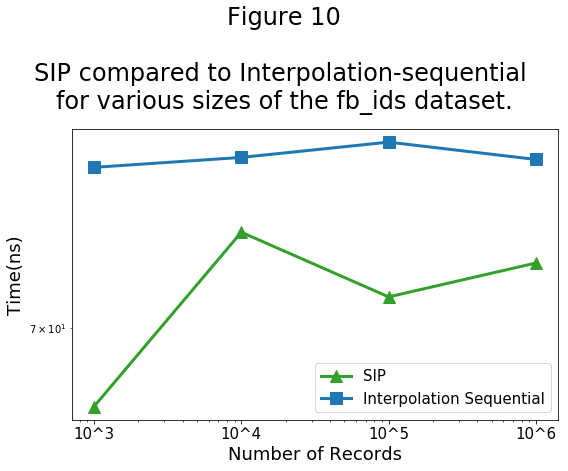

In [10]:
tsv="fig10.tsv"
rm_tsv(tsv)

datasetSizes = [3,4,5,6]
for algorithm in ["sip", "isseq"]:
    for datasetSize in datasetSizes:
            fbids_to_tsv(tsv, algorithm, 32, 1)
            fbids_to_tsv(tsv, algorithm, 32, 1)
            fbids_to_tsv(tsv, algorithm, 32, 1)
            fbids_to_tsv(tsv, algorithm, 32, 1)

run(tsv)
results=get_results(tsv)[0::4]

if makePlots:
    # Group by algorithm
    sipResults = results[0:(len(results)//2)]
    isseqResults = results[(len(results)//2):len(results)]


    fig, ax = plt.subplots(figsize=(8,5))

    plt.plot([10**i for i in datasetSizes], sipResults, color=green,marker="^", markersize=12, linewidth=3, label="SIP")
    plt.plot([10**i for i in datasetSizes], isseqResults, color=blue,marker="s", markersize=12, linewidth=3, label="Interpolation Sequential")

    ax.set_ylabel('Time(ns)', size=18)
    ax.set_xlabel('Number of Records', size=18)
    ax.set_xscale('log')
    ax.set_yscale('log')

    # Set the position of the x ticks
    ax.set_xticks([10**i for i in datasetSizes] )
    ax.set_xticklabels(["10^"+str(i) for i in datasetSizes], size=15)
    ax.tick_params(axis='y', labelsize=15)

    # Adding the legend and showing the plot
    plt.legend(prop={'size': 15}, loc='lower right')
    caption = "Figure 10\n\nSIP compared to Interpolation-sequential \nfor various sizes of the fb_ids dataset."
    fig.suptitle(caption, fontsize=24, x=0.5, y=1.3)
    plt.tight_layout()
    plt.gcf().savefig('./figures/fig10.pdf', format='pdf',bbox_inches='tight')

#### Figure 11

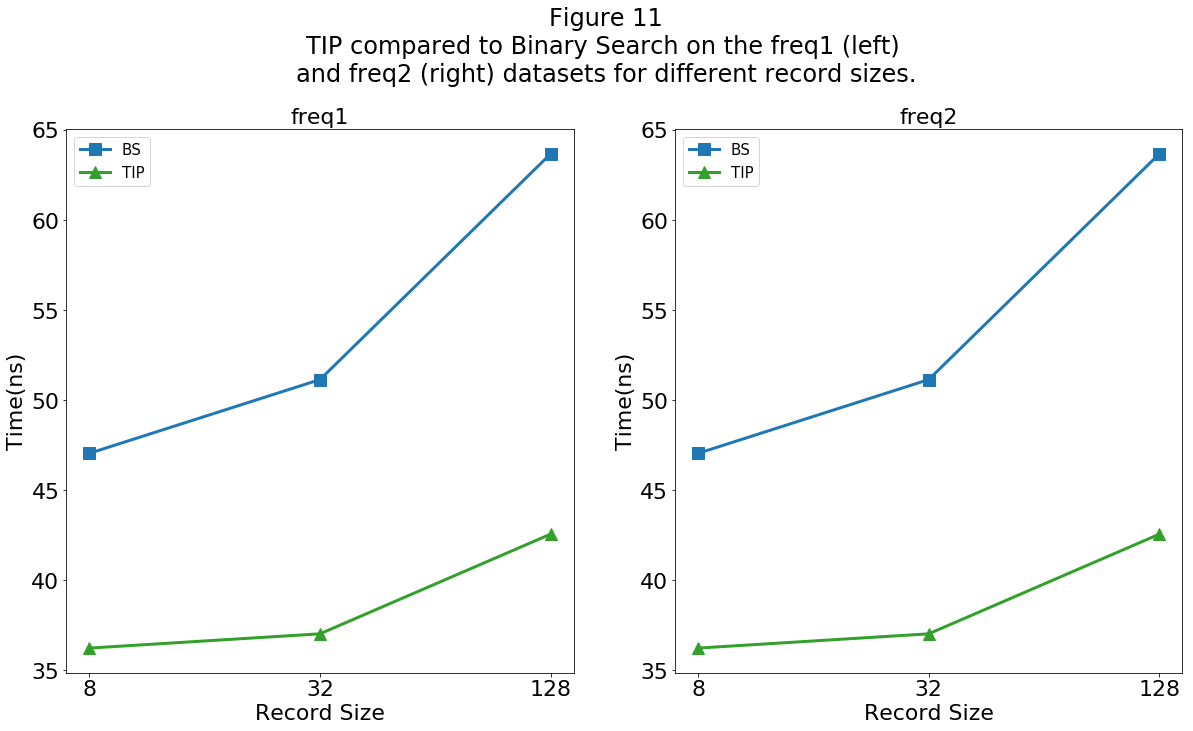

In [11]:
tsv="fig11.tsv"
rm_tsv(tsv)

for algorithm in ["tip", "bs"]:
    for recordSize in [8,32,128]:
            freq1_to_tsv(tsv, algorithm, recordSize, 1)
            freq1_to_tsv(tsv, algorithm, recordSize, 1)
            freq1_to_tsv(tsv, algorithm, recordSize, 1)
            
for algorithm in ["tip", "bs"]:
    for recordSize in [8,32,128]:
            freq2_to_tsv(tsv, algorithm, recordSize, 1)
            freq2_to_tsv(tsv, algorithm, recordSize, 1)
            freq2_to_tsv(tsv, algorithm, recordSize, 1)
    

run(tsv)
results=get_results(tsv)[0::3]

if makePlots:
    freq1Res = results[0:(len(results)//2)]
    freq2Res = results[(len(results)//2):len(results)]

    freq1ResultsTIP = freq1Res[0:(len(freq1Res)//2)]
    freq1ResultsBS = freq1Res[(len(freq1Res)//2):len(freq1Res)]
    freq2ResultsTIP = freq2Res[0:(len(freq2Res)//2)]
    freq2ResultsBS = freq2Res[(len(freq2Res)//2):len(freq2Res)]

    figs, axs = plt.subplots(1,2,figsize=(20,10))
    axs[0].plot([0,1,2], freq1ResultsBS,  color=blue,marker="s", markersize=12, linewidth=3, label="BS")
    axs[0].plot([0,1,2], freq1ResultsTIP,  color=green,marker="^", markersize=12, linewidth=3, label="TIP")

    axs[1].plot([0,1,2], freq1ResultsBS,  color=blue,marker="s", markersize=12, linewidth=3, label="BS")
    axs[1].plot([0,1,2], freq1ResultsTIP,  color=green,marker="^", markersize=12, linewidth=3, label="TIP")

    for i in range(0,2):
        axs[i].set_xticks([0,1,2])
        axs[i].set_xticklabels(["8","32","128"], size=22)
        axs[i].legend(prop={'size': 15}, loc='upper left') 
        axs[i].set_ylabel('Time(ns)', size=22)
        axs[i].set_xlabel('Record Size', size=22)
        axs[i].tick_params(axis='y', labelsize=22)

    axs[0].set_title('freq1', size=22)
    axs[1].set_title('freq2', size=22)

    caption="Figure 11\nTIP compared to Binary Search on the freq1 (left) \nand freq2 (right) datasets for different record sizes."
    figs.suptitle(caption, fontsize=24, x=0.5, y=1.05)

    plt.gcf().savefig('./figures/fig11.pdf', format='pdf', bbox_inches='tight')

#### Figure 12

In [12]:
tsv="fig12.tsv"
rm_tsv(tsv)

#TODO(faster)
for datasetSize in [3,4,5]:#6,7,8]:
        UaR_to_tsv(tsv, 10**datasetSize, "sip", 8, 1,42)

run(tsv)
results=get_results(tsv)
print(results)

# X: Numver of records(log)
# Y: times

[20.516, 20.7054, 29.86381]


#### Figure 18

In [13]:
tsv="fig18.tsv"
rm_tsv(tsv)

#TODO(faster)
for algorithm in ["bs", "sip"]:
    for threads in [2,8,16,32]:
        UaR_to_tsv(tsv, 10**4, algorithm, 8, threads,42)
#         UaR_to_tsv(tsv, 10**8, "sip", 8, threads,42)

run(tsv)
results=get_results(tsv)
print(results)

# X: Numver of records(log)
# Y: times

[51.08145, 60.5339, 69.583794, 67.250287, 22.8118, 25.460263, 25.308781, 25.2978]
